In [1]:
%matplotlib inline
import sys
sys.path.append('..')
from ray_optim.plot import Plot
import torch
from matplotlib import pyplot as plt

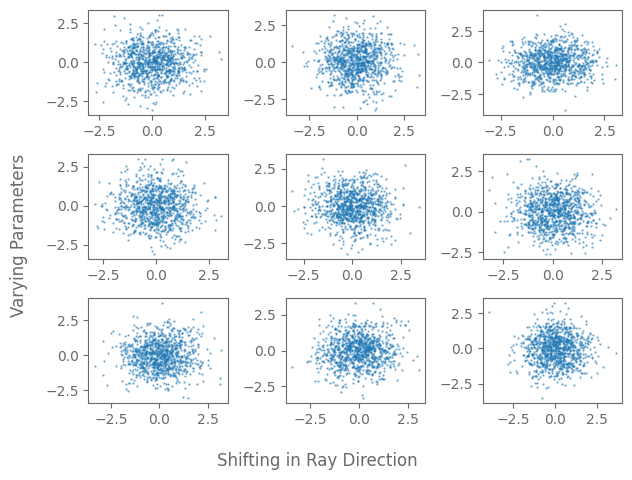

In [2]:
fig = Plot.plot_data([torch.randn(3, 1000, 2) for i in range(3)])
plt.figure(fig)

In [3]:
samples_count = 14
compensated = [torch.randn(3, 1000, 2) * 0.1 + 0.1 for _ in range(samples_count)]
target = [torch.randn(3, 1000, 2) * 0.1 - 1 for _ in range(samples_count)]
without_compensation = compensated
fig = Plot.fixed_position_plot(
    compensated, target, without_compensation, (-2.0, 2.0), (-2.0, 2.0)
)
plt.figure(fig)